# Importing Libraries

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pillow_heif
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from PIL import Image


# Loading the images

In [21]:
# Register HEIF opener with Pillow
# pillow_heif.register_heif_opener()

# === Main dataset folder ===
dataset_path = "/Users/abdulmateen/Downloads/archive (6)/train"
target_size = (224, 224)
images_per_class = 300  # <-- Limit number of images per class

images = []
labels = []
class_names = []

# Map folder names to integer labels
label_map = {}
label_counter = 0

# Loop through each subfolder
for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.isdir(folder_path):
        print(f"Loading class '{folder}' as label {label_counter}")
        label_map[folder] = label_counter
        class_names.append(folder)
        
        # Get image files in folder
        image_files = [
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic'))
        ]

        # Randomly shuffle and select only N
        np.random.shuffle(image_files)
        image_files = image_files[:images_per_class]

        for filename in image_files:
            img_path = os.path.join(folder_path, filename)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label_counter)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        label_counter += 1

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Loaded", len(images), "images from", len(label_map), "classes.")
print("Classes:", label_map)


Loading class 'Bacterial_spot' as label 0
Loading class 'Early_blight' as label 1
Loading class 'Late_blight' as label 2
Loading class 'Leaf_Mold' as label 3
Loading class 'Septoria_leaf_spot' as label 4
Loading class 'Spider_mites Two-spotted_spider_mite' as label 5
Loading class 'Target_Spot' as label 6
Loading class 'Tomato_Yellow_Leaf_Curl_Virus' as label 7
Loading class 'Tomato_mosaic_virus' as label 8
Loading class 'healthy' as label 9
Loading class 'powdery_mildew' as label 10
Loaded 3300 images from 11 classes.
Classes: {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


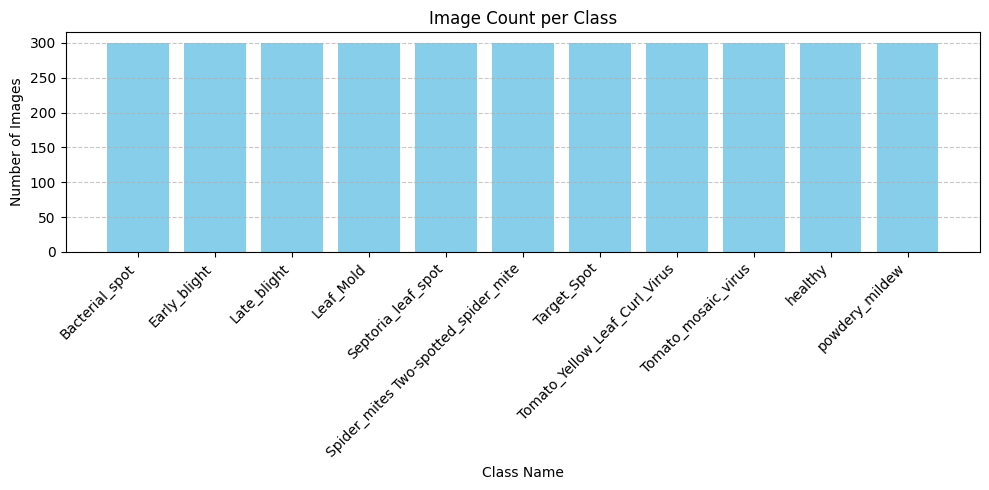

In [22]:
# Count occurrences of each label
label_counts = Counter(labels)

# Map back to class names
class_labels = [class_names[i] for i in label_counts.keys()]
counts = [label_counts[i] for i in label_counts.keys()]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Image Count per Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [23]:
# images = images / 255.0  # Normalize

# 1. Split into train+val and test (80% train+val, 20% test)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2. Split train_val into train and val (e.g., 80% train, 20% val of the 80%)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)





In [24]:

print("Train:", len(train_images))
print("Validation:", len(val_images))
print("Test:", len(test_images))

Train: 2673
Validation: 297
Test: 330


In [10]:
import tensorflow as tf
import numpy as np

# Load the model
model = tf.keras.models.load_model('/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model2_v2.h5')

# --- DO NOT MANUALLY NORMALIZE THE IMAGES ---
# REMOVE THIS LINE: test_images = test_images / 255.0  

# 'test_images' should be the raw images with pixel values from 0-255,
# just as they were when you got the 89.7% accuracy.

print("Evaluating the loaded model with its built-in preprocessing...")
# Evaluate on the original, unscaled test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"\nCorrect Test Accuracy: {test_accuracy:.4f}")
print(f"Correct Test Loss: {test_loss:.4f}")

Evaluating the loaded model with its built-in preprocessing...
31/31 - 9s - 300ms/step - accuracy: 0.0909 - loss: 6.9672

Correct Test Accuracy: 0.0909
Correct Test Loss: 6.9672


# TRAINING WITH RESNET

In [6]:


# Define number of classes
num_classes = 11  # Replace with your actual number of classes

# Input layer
inputs = keras.Input(shape=(224, 224, 3))

# Rescale input images (optional – handled in data augmentation pipeline)
x = layers.Rescaling(1./255)(inputs)
# x = inputs  # Use input directly if rescaling is done elsewhere

# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Pass through base model
x = base_model(x, training=False)

# Add pooling, dropout, and final dense layer
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
#  kernel_regularizer=tf.keras.regularizers.l2(0.001)
# Build model
model1 = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model1.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,195 (8.69 MB)

 Trainable params: 16,651 (65.04 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [31]:

datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

train_generator = datagen.flow(
    train_images, train_labels,
    subset='training',
    batch_size=32
)

val_generator = datagen.flow(
    val_images, val_labels,
    subset='validation',
    batch_size=32
)




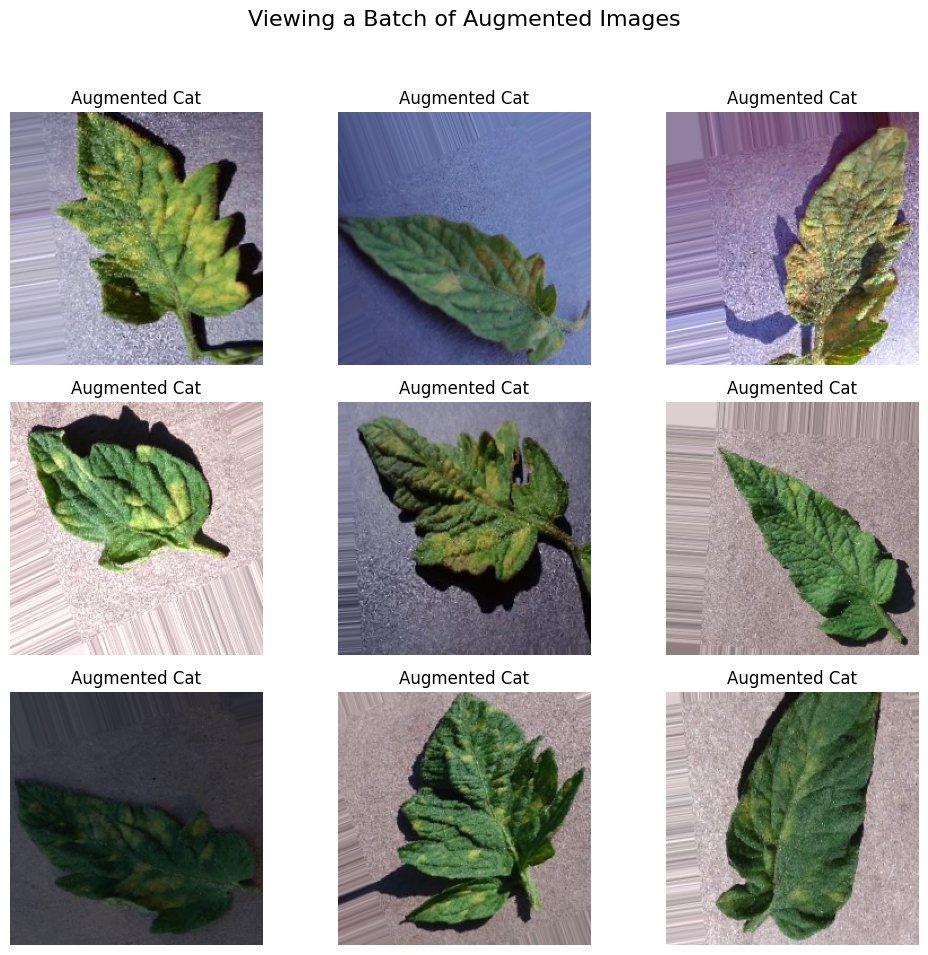

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10 # Using a sample dataset for demonstration

# --- 1. Load Sample Data ---
# Let's use 9 images of 'cats' from the CIFAR-10 dataset
# (x_train, y_train), (_, _) = cifar10.load_data()
cat_images = images[labels.flatten() == 3][:9] # Class 3 is cats

# --- 2. Define the Augmentation Generator ---
datagen = ImageDataGenerator(
    # rescale=1./255,
    brightness_range=[0.5, 1.5],
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- 3. Generate ONE Batch of Augmented Images ---
# We create a generator that will produce batches of 9 augmented images
image_generator = datagen.flow(cat_images, batch_size=9, shuffle=False)

# Get the first (and only) batch
augmented_batch = next(image_generator)

# --- 4. Visualize the Results ---
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # The generator normalizes images, so we convert them back to integers for viewing
    image = augmented_batch[i].astype('uint8')
    plt.imshow(image)
    plt.title("Augmented Cat")
    plt.axis("off")

plt.suptitle("Viewing a Batch of Augmented Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:


# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',     # you can also use 'val_accuracy'
    patience=3,             # number of epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)


In [8]:
history1 = model1.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=20,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# history = model1.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=20,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator)
# )


Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 104s 331ms/step - accuracy: 0.4268 - loss: 2.0233 - val_accuracy: 0.7077 - val_loss: 0.8396
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 89s 293ms/step - accuracy: 0.6947 - loss: 0.9584 - val_accuracy: 0.7789 - val_loss: 0.6951
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 90s 297ms/step - accuracy: 0.7441 - loss: 0.7880 - val_accuracy: 0.7993 - val_loss: 0.6572
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 91s 299ms/step - accuracy: 0.7693 - loss: 0.6882 - val_accuracy: 0.8057 - val_loss: 0.6203
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 92s 303ms/step - accuracy: 0.7711 - loss: 0.6759 - val_accuracy: 0.8076 - val_loss: 0.6215
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 91s 300ms/step - accuracy: 0.7790 - loss: 0.6643 - val_accuracy: 0.8067 - val_loss: 0.6162
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 91s 300ms/step - accuracy: 0.7854 - loss: 0.6479 - val_accuracy: 0.8205 - val_loss: 0.5957
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.7928 - loss: 

In [9]:
model1.save("model3_v1.h5")

In [10]:
# Unfreeze last part of base model
base_model.trainable = True
fine_tune_at = 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# checkpoint = ModelCheckpoint(
#     filepath='best_model.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',             # fix: use mode, not model
#     verbose=1
# )

fine_tune_history1 = model1.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=25,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# fine_tune_history1 = model1.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=25,
#     verbose=1,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_images) // 32,
# )


Epoch 1/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 260s 826ms/step - accuracy: 0.5283 - loss: 1.6733 - val_accuracy: 0.7317 - val_loss: 0.9798
Epoch 2/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 239s 786ms/step - accuracy: 0.7085 - loss: 0.9864 - val_accuracy: 0.7586 - val_loss: 0.9224
Epoch 3/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 239s 784ms/step - accuracy: 0.7752 - loss: 0.7250 - val_accuracy: 0.7734 - val_loss: 0.8262
Epoch 4/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 240s 788ms/step - accuracy: 0.8000 - loss: 0.6177 - val_accuracy: 0.8067 - val_loss: 0.6812
Epoch 5/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 239s 785ms/step - accuracy: 0.8340 - loss: 0.4969 - val_accuracy: 0.8307 - val_loss: 0.5774
Epoch 6/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 240s 787ms/step - accuracy: 0.8507 - loss: 0.4350 - val_accuracy: 0.8501 - val_loss: 0.5056
Epoch 7/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 239s 787ms/step - accuracy: 0.8762 - loss: 0.3731 - val_accuracy: 0.8474 - val_loss: 0.4720
Epoch 8/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 240s 788ms/step - accuracy: 0.8909 -

: 

In [ ]:
model1.save("model3_v3.h5")

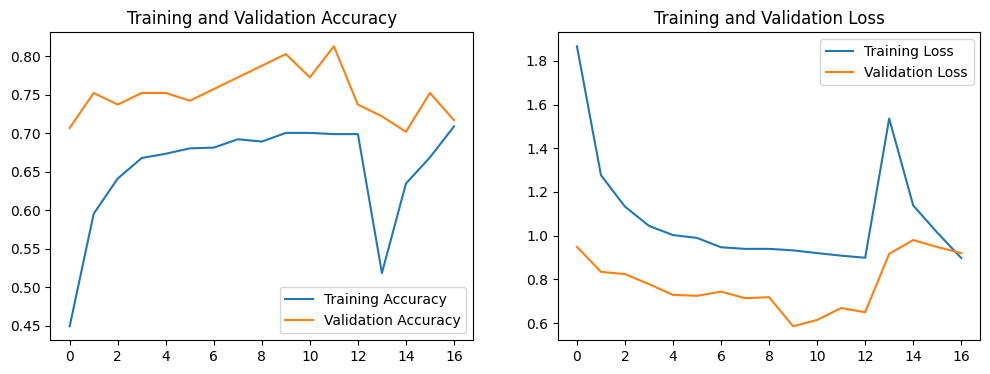

In [34]:
acc = history.history['accuracy'] + fine_tune_history1.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history1.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history1.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history1.history['val_loss']

# acc = history.history['accuracy'] 
# val_acc = history.history['val_accuracy'] 
# loss = history.history['loss'] 
# val_loss = history.history['val_loss'] 


# acc =  fine_tune_history1.history['accuracy']
# val_acc = fine_tune_history1.history['val_accuracy']
# loss =  fine_tune_history1.history['loss']
# val_loss =  fine_tune_history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
from tensorflow import keras

m2 = '/Users/abdulmateen/Downloads/tomato-disease-detection-model.h5'

# Load without compiling (skips the incompatible loss/metrics settings)
model1 = keras.models.load_model(m2, compile=False)

# Recompile with a valid loss & metrics for your task
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',   # or 'sparse_categorical_crossentropy' depending on your labels
    metrics=['accuracy']
)


In [39]:

m1 = '/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model1.h5'
m2 = '/Users/abdulmateen/Downloads/tomato-disease-detection-model.h5'
m3 = '/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model2_v2.h5'
model1 = tf.keras.models.load_model(m3)
# Register HEIF opener with Pill2w
pillow_heif.register_heif_opener()

def predict_single_image(model, image_path, class_names, target_size=(224, 224), show_image=True):
    """
    Make prediction on a single external image
    
    Args:
        model: Your trained Keras model
        image_path: Path to the image file
        class_names: List of class names (same order as training)
        target_size: Input size expected by model (224, 224)
        show_image: Whether to display the image
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score (0-1)
        all_predictions: Array of all class probabilities
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed (handles HEIC, PNG with transparency, etc.)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to target size
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        
        # Get the predicted class and confidence
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        # Display the image if requested
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.2%})')
            plt.axis('off')
            plt.show()
        
        return predicted_class, confidence, predictions[0]
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def predict_multiple_images(model, image_folder, class_names, target_size=(224, 224), show_results=True):
    """
    Make predictions on multiple images in a folder
    
    Args:
        model: Your trained Keras model
        image_folder: Path to folder containing images
        class_names: List of class names
        target_size: Input size expected by model
        show_results: Whether to display results
    
    Returns:
        results: List of dictionaries with results for each image
    """
    results = []
    
    # Get all image files in the folder
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic')
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(image_extensions)]
    
    print(f"Found {len(image_files)} images to process")
    
    for i, filename in enumerate(image_files):
        image_path = os.path.join(image_folder, filename)
        print(f"\nProcessing {i+1}/{len(image_files)}: {filename}")
        
        predicted_class, confidence, all_predictions = predict_single_image(
            model, image_path, class_names, target_size, show_image=show_results
        )
        
        if predicted_class is not None:
            result = {
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_predictions': all_predictions
            }
            results.append(result)
            
            print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")
        else:
            print(f"Failed to process {filename}")
    
    return results

def show_top_predictions(predictions, class_names, top_n=3):
    """
    Display top N predictions with their probabilities
    
    Args:
        predictions: Array of prediction probabilities
        class_names: List of class names
        top_n: Number of top predictions to show
    """
    # Get indices of top predictions
    top_indices = np.argsort(predictions)[::-1][:top_n]
    
    print(f"\nTop {top_n} predictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[idx]:.2%}")

# Example usage functions
def predict_with_your_model(image_path):
    """
    Wrapper function using your specific model and class names
    """
    # Your class names from the training
    # class_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
    class_names = ['Bacterial-spot',
    'Early-blight',
    'Healthy',
    'Late-blight',
    'Leaf-mold',
    'Mosaic-virus',
    'Septoria-leaf-spot',
    'Yellow-leaf-curl-virus']
        # Make prediction
    predicted_class, confidence, all_predictions = predict_single_image(
        model1, image_path, class_names, target_size=(224, 224), show_image=True
    )
    
    if predicted_class is not None:
        print(f"\nPredicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        
        # Show top 3 predictions
        show_top_predictions(all_predictions, class_names, top_n=3)
    
    return predicted_class, confidence, all_predictions

# Example usage:
# predicted_class, confidence, all_predictions = predict_with_your_model('/path/to/your/image.jpg')

# For batch processing:
# results = predict_multiple_images(model, '/path/to/image/folder', class_names)

In [16]:
def predict_single_image(model, image_path, class_names, target_size=(224, 224), show_image=True):
    """
    Make prediction on a single external image
    
    Args:
        model: Your trained Keras model
        image_path: Path to the image file
        class_names: List of class names (same order as training)
        target_size: Input size expected by model (224, 224)
        show_image: Whether to display the image
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score (0-1)
        all_predictions: Array of all class probabilities
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed (handles HEIC, PNG with transparency, etc.)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to target size
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        
        # Get the predicted class and confidence
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        # Display the image if requested
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.2%})')
            plt.axis('off')
            plt.show()
        
        return predicted_class, confidence, predictions[0]
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def predict_multiple_images(model, image_folder, class_names, target_size=(224, 224), show_results=True):
    """
    Make predictions on multiple images in a folder
    
    Args:
        model: Your trained Keras model
        image_folder: Path to folder containing images
        class_names: List of class names
        target_size: Input size expected by model
        show_results: Whether to display results
    
    Returns:
        results: List of dictionaries with results for each image
    """
    results = []
    
    # Get all image files in the folder
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic')
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(image_extensions)]
    
    print(f"Found {len(image_files)} images to process")
    
    for i, filename in enumerate(image_files):
        image_path = os.path.join(image_folder, filename)
        print(f"\nProcessing {i+1}/{len(image_files)}: {filename}")
        
        predicted_class, confidence, all_predictions = predict_single_image(
            model, image_path, class_names, target_size, show_image=show_results
        )
        
        if predicted_class is not None:
            result = {
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_predictions': all_predictions
            }
            results.append(result)
            
            print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")
        else:
            print(f"Failed to process {filename}")
    
    return results

def show_top_predictions(predictions, class_names, top_n=3):
    """
    Display top N predictions with their probabilities
    
    Args:
        predictions: Array of prediction probabilities
        class_names: List of class names
        top_n: Number of top predictions to show
    """
    # Get indices of top predictions
    top_indices = np.argsort(predictions)[::-1][:top_n]
    
    print(f"\nTop {top_n} predictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[idx]:.2%}")

# Example usage functions
def predict_with_your_model(image_path):
    """
    Wrapper function using your specific model and class names
    """
    # Your class names from the training
    # class_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
    class_names = ['Bacterial-spot',
    'Early-blight',
    'Healthy',
    'Late-blight',
    'Leaf-mold',
    'Mosaic-virus',
    'Septoria-leaf-spot',
    'Yellow-leaf-curl-virus']
        # Make prediction
    predicted_class, confidence, all_predictions = predict_single_image(
        model1, image_path, class_names, target_size=(224, 224), show_image=True
    )
    
    if predicted_class is not None:
        print(f"\nPredicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        
        # Show top 3 predictions
        show_top_predictions(all_predictions, class_names, top_n=3)
    
    return predicted_class, confidence, all_predictions


In [40]:
predicted_class, confidence, all_predictions = predict_with_your_model('/Users/abdulmateen/Downloads/archive (6)/valid/Leaf_Mold/0eda4dc5-7f7b-4e27-9e53-1e0326eef88e___Crnl_L.Mold 8850.JPG')


Error processing image /Users/abdulmateen/Downloads/archive (6)/valid/Leaf_Mold/0eda4dc5-7f7b-4e27-9e53-1e0326eef88e___Crnl_L.Mold 8850.JPG: list index out of range


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step


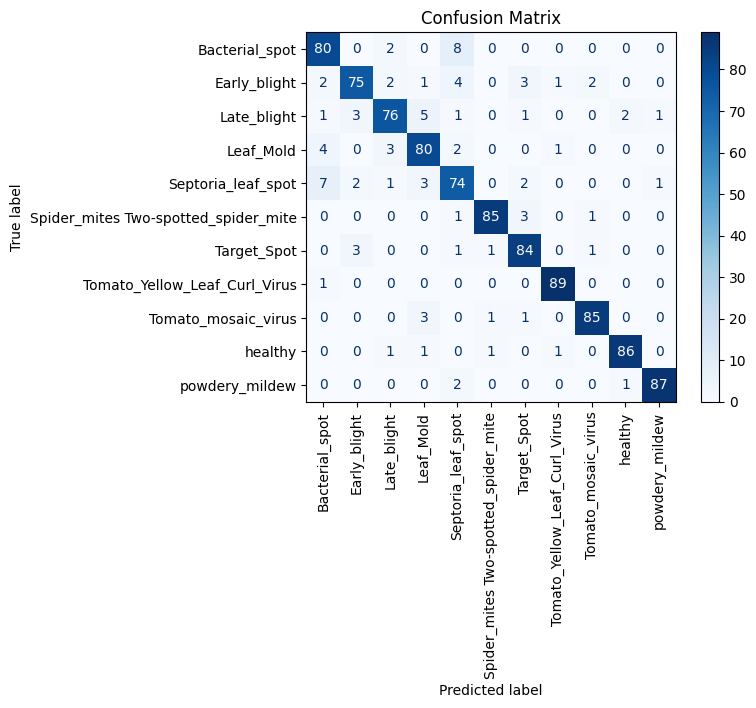

In [12]:

def plot_confusion_matrix(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


plot_confusion_matrix(model1, test_images, test_labels, class_names)


In [68]:

def print_classification_report(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    print(classification_report(y_test, y_pred_labels, target_names=class_names))


In [69]:

print_classification_report(model1, test_images, test_labels, class_names)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.89      0.82      0.86        90
                        Early_blight       0.79      0.87      0.83        90
                         Late_blight       0.84      0.81      0.82        90
                           Leaf_Mold       0.90      0.79      0.84        90
                  Septoria_leaf_spot       0.85      0.80      0.82        90
Spider_mites Two-spotted_spider_mite       0.89      0.98      0.93        90
                         Target_Spot       0.95      0.89      0.92        90
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.98      0.98        90
                 Tomato_mosaic_virus       0.96      0.98      0.97        90
                             healthy       0.94      0.99      0.96        90
                      powdery_mildew       0.89      0.97      0.93        90

                     

In [51]:


def evaluate_model(model, X_test, y_test, class_names):
    # Predict and convert to label indices
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Accuracy score
    acc = accuracy_score(y_test, y_pred_labels)
    print(f"Accuracy: {acc:.4f}\n")

 

evaluate_model(model1, test_images, test_labels, class_names)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step
Accuracy: 0.9242



In [41]:
import tensorflow as tf
import os

def quantize_model_dynamic_range(keras_model, save_path):
  """
  Converts a Keras model to a TFLite model with dynamic range quantization.

  Args:
    keras_model: The trained TensorFlow/Keras model instance.
    save_path: The file path where the quantized .tflite model will be saved.
  """
  # Initialize the TFLiteConverter from the Keras model
  converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
  
  # Set the optimization strategy to default, which enables dynamic range quantization
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  
  # Convert the model
  tflite_quant_model = converter.convert()
  
  # Save the quantized model to the specified path
  with open(save_path, 'wb') as f:
    f.write(tflite_quant_model)
    
  print(f"✅ Successfully saved dynamically quantized model to: {save_path}")
#   original_size = os.path.getsize(f'{models_dir}/{model_ver}') / (1024 * 1024)
  quantized_size = len(tflite_quant_model) / (1024 * 1024)
  print(f"Original model size: {original_size:.2f} MB")
  print(f"Quantized model size: {quantized_size:.2f} MB")
  print(f"Size reduction: {(1 - quantized_size / original_size) * 100:.2f}%")

In [55]:
import tensorflow as tf
import os

def quantize_model_dynamic_range(keras_model, save_path):
    """
    Converts a Keras model to a TFLite model with dynamic range quantization,
    ensuring broader compatibility with older runtimes.
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # --- FIX: Add this line for better compatibility ---
    # This tells the converter to only use the core, standard set of TFLite operations.
    converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,      # default ops
    tf.lite.OpsSet.SELECT_TF_OPS         # enable fallback to TF ops
]

    # --- END OF FIX ---
    
    tflite_quant_model = converter.convert()
    
    with open(save_path, 'wb') as f:
        f.write(tflite_quant_model)
        
    print(f"✅ Successfully saved dynamically quantized model to: {save_path}")
    quantized_size = len(tflite_quant_model) / (1024 * 1024)
    print(f"Quantized model size: {quantized_size:.2f} MB")

In [ ]:
# Assuming your trained model object is named 'model'
# And your models directory is 'models_dir'

# Define the path for the new quantized model
quantized_model_path = "model1.tflite"
# quantized_model_path = os.path.join(models_dir, quantized_model_filename)

# Call the quantization function
quantize_model_dynamic_range(model1, quantized_model_path)

INFO:tensorflow:Assets written to: /var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmpeh3gm5wz/assets


INFO:tensorflow:Assets written to: /var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmpeh3gm5wz/assets


Saved artifact at '/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmpeh3gm5wz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  5625094640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624242496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624235808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624246368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624243024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624240032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624241264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624234400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624239680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624240560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5624246016: TensorSp

W0000 00:00:1756208612.691592  346980 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756208612.691929  346980 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [58]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Configuration ---
# 1. Update with the path to your trained Keras .h5 model
KERAS_MODEL_PATH = '/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model2_v2.h5'

# 2. Update with the path to your training image directory
DATASET_PATH = "/Users/abdulmateen/Downloads/archive (6)/train"

# 3. Define where to save the final .tflite model
TFLITE_INT8_MODEL_PATH = "model_quantized_int8.tflite"

# 4. Set parameters
TARGET_SIZE = (224, 224)
REPRESENTATIVE_SAMPLES = 100 # Number of images for the representative dataset

# --- Data Loading Function ---
def load_representative_data(dataset_path, num_samples):
    """Loads a small subset of images to be used for quantization."""
    print(f"Loading {num_samples} representative images...")
    images = []
    # Find all subdirectories (which are the classes)
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    # Calculate how many images to grab from each class
    samples_per_class = max(1, num_samples // len(class_dirs))
    
    for class_dir in class_dirs:
        class_path = os.path.join(dataset_path, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Take a small, random sample from each class
        for image_file in np.random.choice(image_files, samples_per_class, replace=False):
            img_path = os.path.join(class_path, image_file)
            img = load_img(img_path, target_size=TARGET_SIZE)
            img_array = img_to_array(img)
            images.append(img_array)
            
    return np.array(images, dtype=np.float32)

# --- Main Quantization Function ---
def quantize_model_full_integer(keras_model, representative_data, save_path):
    """Converts a Keras model to a TFLite model with full integer quantization."""
    
    # 1. Define the Representative Dataset Generator
    def representative_dataset_gen():
        for image in representative_data:
            # The generator must yield a list of NumPy arrays
            yield [np.expand_dims(image, axis=0)]

    # 2. Initialize the TFLiteConverter
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    
    # 3. Set Quantization Configurations for Full Integer Quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    
    # Enforce full integer quantization for inputs and outputs
    # This is the key to making it compatible with older mobile runtimes
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8  # or tf.int8
    converter.inference_output_type = tf.uint8 # or tf.int8
    
    # 4. Convert the model
    print("Starting full integer quantization...")
    tflite_quant_model = converter.convert()
    print("✅ Quantization complete.")
    
    # 5. Save the quantized model
    with open(save_path, 'wb') as f:
        f.write(tflite_quant_model)
        
    print(f"✅ Successfully saved fully quantized model to: {save_path}")
    quantized_size = len(tflite_quant_model) / (1024 * 1024)
    print(f"Quantized model size: {quantized_size:.2f} MB")

# --- Execute the script ---
if __name__ == '__main__':
    # Load the trained Keras model
    model = tf.keras.models.load_model(KERAS_MODEL_PATH)
    
    # Load the representative data
    representative_images = load_representative_data(DATASET_PATH, REPRESENTATIVE_SAMPLES)
    
    # Run the quantization process
    quantize_model_full_integer(model, representative_images, TFLITE_INT8_MODEL_PATH)

Loading 100 representative images...
Starting full integer quantization...
INFO:tensorflow:Assets written to: /var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmp1h3g9ska/assets


INFO:tensorflow:Assets written to: /var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmp1h3g9ska/assets


Saved artifact at '/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/tmp1h3g9ska'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  5522728112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522822016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522824128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522817440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522819728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522827120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522827296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522829056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522825888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522828352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5522830992: TensorSp

/Users/abdulmateen/opt/anaconda3/envs/yagi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1756209651.807193  346980 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756209651.807702  346980 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ Quantization complete.
✅ Successfully saved fully quantized model to: model_quantized_int8.tflite
Quantized model size: 2.60 MB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [14]:
# FIXED VERSION - Remove MobileNetV2 preprocessing since your model has Rescaling layer

# Remove this preprocessing function entirely or make it a simple cast
@tf.function
def preprocess_image(image):
    """Simple cast to float32 - no normalization since model has Rescaling layer."""
    return tf.cast(image, tf.float32)

# Alternative: Just use the images directly without any preprocessing function
# since your model already has the Rescaling(1./255) layer built-in

# ==============================================================================
# --- FIXED QUANTIZATION ---
# ==============================================================================
def quantize_model(keras_model, representative_images):
    print("\nStarting model quantization...")
    
    def representative_dataset_gen():
        for image in representative_images:
            # Just cast to float32 and add batch dimension
            # No MobileNetV2 preprocessing since your model has Rescaling layer
            img_batch = tf.cast(np.expand_dims(image, axis=0), tf.float32)
            yield [img_batch.numpy()]

    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    
    # For full integer quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    tflite_quantized_model = converter.convert()
    
    with open(QUANTIZED_MODEL_PATH, 'wb') as f:
        f.write(tflite_quantized_model)
        
    print(f"✅ Quantized model saved to: {QUANTIZED_MODEL_PATH}")
    return tflite_quantized_model

# ==============================================================================
# --- FIXED EVALUATION ---
# ==============================================================================
def evaluate_tflite_model(model_path, test_images, test_labels):
    """Evaluates a TFLite model's accuracy on the test set."""
    print(f"\nEvaluating model: {model_path}")
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    predictions = []
    is_quantized = input_details['dtype'] == np.int8
    
    for image in test_images:
        img_expanded = np.expand_dims(image, axis=0).astype(np.float32)
        
        if is_quantized:
            # For quantized models, quantize the input
            input_scale, input_zero_point = input_details['quantization']
            img_quantized = (img_expanded / input_scale + input_zero_point).astype(np.int8)
            interpreter.set_tensor(input_details['index'], img_quantized)
        else:
            # For float models, use raw float32 input
            interpreter.set_tensor(input_details['index'], img_expanded)
        
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])
        
        if is_quantized:
            # Dequantize output
            output_scale, output_zero_point = output_details['quantization']
            output = (output.astype(np.float32) - output_zero_point) * output_scale
        
        predictions.append(np.argmax(output[0]))
        
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

# ==============================================================================
# --- FIXED MAIN EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    # Step 1: Load and split data
    X_train, y_train, X_test, y_test = load_and_split_data(DATASET_PATH)

    # Step 2: Load the original Keras model
    try:
        original_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
        print(f"\nSuccessfully loaded Keras model from: {KERAS_MODEL_PATH}")
    except Exception as e:
        print(f"🚨 Error loading Keras model: {e}")
        exit()

    # Step 3: Create representative dataset
    representative_indices = np.random.choice(len(X_train), REPRESENTATIVE_SAMPLES, replace=False)
    representative_images = X_train[representative_indices]
    print(f"Created a representative dataset with {REPRESENTATIVE_SAMPLES} images.")

    # Step 4: Quantize the model
    quantize_model(original_model, representative_images)

    # Step 5: Evaluate all models
    print("\n--- Starting Model Accuracy Comparison ---")
    
    # a) Original Keras Model Accuracy - NO PREPROCESSING
    print("\nEvaluating original Keras model...")
    # Just use raw images - the model has Rescaling layer built-in
    keras_preds = np.argmax(original_model.predict(X_test.astype(np.float32)), axis=1)
    keras_accuracy = accuracy_score(y_test, keras_preds)
    
    # b) Quantized TFLite Model Accuracy
    quantized_accuracy = evaluate_tflite_model(QUANTIZED_MODEL_PATH, X_test, y_test)
    
    # Step 6: Print Final Comparison
    original_size = os.path.getsize(KERAS_MODEL_PATH) / (1024 * 1024)
    quantized_size = os.path.getsize(QUANTIZED_MODEL_PATH) / 1024

    print("\n--- 📊 Final Performance Report ---")
    print(f"✅ Original Keras Model (.h5):")
    print(f"   - Accuracy: {keras_accuracy:.4f}")
    print(f"   - Size:     {original_size:.2f} MB")
    print("-" * 40)
    print(f"✅ Quantized TFLite Model (.tflite):")
    print(f"   - Accuracy: {quantized_accuracy:.4f}")
    print(f"   - Size:     {quantized_size:.2f} KB")
    print("-" * 40)
    
    accuracy_change = ((quantized_accuracy - keras_accuracy) / keras_accuracy) * 100
    print(f"Accuracy change after quantization: {accuracy_change:+.2f}%")

NameError: name 'load_and_split_data' is not defined

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# ==============================================================================
# --- CONFIGURATION ---
# ==============================================================================
QUANTIZED_MODEL_PATH = "/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model_quantized.tflite"
TARGET_SIZE = (224, 224)

# Update these with your actual class names from training
CLASS_NAMES =  ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']

  # Replace with your actual class names

# ==============================================================================
# --- QUANTIZED MODEL PREDICTOR CLASS ---
# ==============================================================================
class QuantizedModelPredictor:
    def __init__(self, model_path, class_names):
        """Initialize the quantized model predictor."""
        self.model_path = model_path
        self.class_names = class_names
        
        # Load the TFLite model
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        
        # Get input and output details
        self.input_details = self.interpreter.get_input_details()[0]
        self.output_details = self.interpreter.get_output_details()[0]
        
        # Check if model is quantized
        self.is_quantized = self.input_details['dtype'] == np.int8
        
        print(f"📋 Model loaded: {model_path}")
        print(f"📋 Input shape: {self.input_details['shape']}")
        print(f"📋 Input dtype: {self.input_details['dtype']}")
        print(f"📋 Is quantized: {self.is_quantized}")
        if self.is_quantized:
            print(f"📋 Input quantization: scale={self.input_details['quantization'][0]}, zero_point={self.input_details['quantization'][1]}")
    
    def preprocess_image(self, image_path):
        """Load and preprocess an image for prediction."""
        try:
            # Load image
            img = Image.open(image_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize to target size
            img = img.resize(TARGET_SIZE)
            
            # Convert to numpy array
            img_array = np.array(img, dtype=np.float32)
            
            # Add batch dimension
            img_batch = np.expand_dims(img_array, axis=0)
            
            return img_batch, img_array
            
        except Exception as e:
            print(f"❌ Error loading image {image_path}: {e}")
            return None, None
    
    def predict_single_image(self, image_path, show_image=True, top_k=3):
        """Predict class for a single image."""
        print(f"\n🔍 Predicting: {os.path.basename(image_path)}")
        
        # Preprocess image
        img_batch, img_display = self.preprocess_image(image_path)
        if img_batch is None:
            return None
        
        # Prepare input for the model
        if self.is_quantized:
            # Quantize input for quantized model
            input_scale, input_zero_point = self.input_details['quantization']
            img_quantized = (img_batch / input_scale + input_zero_point).astype(np.int8)
            self.interpreter.set_tensor(self.input_details['index'], img_quantized)
        else:
            # Use float input for float model
            self.interpreter.set_tensor(self.input_details['index'], img_batch)
        
        # Run inference
        self.interpreter.invoke()
        
        # Get output
        output = self.interpreter.get_tensor(self.output_details['index'])
        
        # Dequantize output if necessary
        if self.is_quantized:
            output_scale, output_zero_point = self.output_details['quantization']
            output = (output.astype(np.float32) - output_zero_point) * output_scale
        
        # Get probabilities
        probabilities = tf.nn.softmax(output[0]).numpy()
        
        # Get top predictions
        top_indices = np.argsort(probabilities)[::-1][:top_k]
        
        # Display results
        print(f"📊 Top {top_k} predictions:")
        for i, idx in enumerate(top_indices):
            class_name = self.class_names[idx] if idx < len(self.class_names) else f"Class_{idx}"
            confidence = probabilities[idx] * 100
            print(f"   {i+1}. {class_name}: {confidence:.2f}%")
        
        # Show image if requested
        if show_image and img_display is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(img_display.astype(np.uint8))
            plt.title(f"Predicted: {self.class_names[top_indices[0]]} ({probabilities[top_indices[0]]*100:.1f}%)")
            plt.axis('off')
            plt.show()
        
        return {
            'predicted_class': self.class_names[top_indices[0]] if top_indices[0] < len(self.class_names) else f"Class_{top_indices[0]}",
            'confidence': probabilities[top_indices[0]],
            'all_probabilities': probabilities,
            'top_predictions': [(self.class_names[idx] if idx < len(self.class_names) else f"Class_{idx}", probabilities[idx]) for idx in top_indices]
        }
    
    def predict_batch(self, image_paths, show_images=False):
        """Predict classes for multiple images."""
        results = []
        
        print(f"\n🔍 Predicting {len(image_paths)} images...")
        
        for i, image_path in enumerate(image_paths):
            print(f"\nProgress: {i+1}/{len(image_paths)}")
            result = self.predict_single_image(image_path, show_image=show_images, top_k=1)
            if result:
                results.append({
                    'image_path': image_path,
                    'predicted_class': result['predicted_class'],
                    'confidence': result['confidence']
                })
        
        return results


In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import pillow_heif

# Register HEIF opener with Pillow
pillow_heif.register_heif_opener()

# ==============================================================================
# --- QUANTIZED MODEL TESTING (Matching your original workflow) ---
# ==============================================================================

QUANTIZED_MODEL_PATH = "/Users/abdulmateen/tensorflow-test/mlproject/segmentation/tomato_disease_model_dynamic.tflite"

# Your class names from training
CLASS_NAMES = [
    'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 
    'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 
    'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 
    'healthy', 'powdery_mildew'
]


# Load the quantized model once
try:
    interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    is_quantized = input_details['dtype'] == np.int8
    print(f"✅ Quantized model loaded successfully")
    print(f"📋 Input dtype: {input_details['dtype']}")
    print(f"📋 Is quantized: {is_quantized}")
except Exception as e:
    print(f"❌ Error loading quantized model: {e}")
    interpreter = None

def predict_single_image_quantized(image_path, class_names=CLASS_NAMES, target_size=(224, 224), show_image=True):
    """
    Make prediction on a single external image using quantized model
    (Matches your original predict_single_image function)
    
    Args:
        image_path: Path to the image file
        class_names: List of class names (same order as training)
        target_size: Input size expected by model (224, 224)
        show_image: Whether to display the image
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score (0-1)
        all_predictions: Array of all class probabilities
    """
    if interpreter is None:
        print("❌ Model not loaded. Please check the model path.")
        return None, None, None
    
    try:
        # Load and preprocess the image (EXACTLY like your original)
        img = Image.open(image_path)
        
        # Convert to RGB if needed (handles HEIC, PNG with transparency, etc.)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to target size
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction with quantized model
        if is_quantized:
            # For quantized models, quantize the input
            input_scale, input_zero_point = input_details['quantization']
            img_quantized = (img_array / input_scale + input_zero_point).astype(np.int8)
            interpreter.set_tensor(input_details['index'], img_quantized)
        else:
            # For float models, use raw float32 input
            interpreter.set_tensor(input_details['index'], img_array)
        
        # Run inference
        interpreter.invoke()
        
        # Get output
        output = interpreter.get_tensor(output_details['index'])
        
        # Dequantize output if necessary
        if is_quantized:
            output_scale, output_zero_point = output_details['quantization']
            output = (output.astype(np.float32) - output_zero_point) * output_scale
        
        # Convert to probabilities (like your original)
        predictions = tf.nn.softmax(output[0]).numpy()
        
        # Get the predicted class and confidence (EXACTLY like your original)
        predicted_class_idx = np.argmax(predictions)
        confidence = predictions[predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        # Display the image if requested (EXACTLY like your original)
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.2%})')
            plt.axis('off')
            plt.show()
        
        return predicted_class, confidence, predictions
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def predict_multiple_images_quantized(image_folder, class_names=CLASS_NAMES, target_size=(224, 224), show_results=True):
    """
    Make predictions on multiple images in a folder using quantized model
    (Matches your original predict_multiple_images function)
    
    Args:
        image_folder: Path to folder containing images
        class_names: List of class names
        target_size: Input size expected by model
        show_results: Whether to display results
    
    Returns:
        results: List of dictionaries with results for each image
    """
    results = []
    
    # Get all image files in the folder (EXACTLY like your original)
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic')
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(image_extensions)]
    
    print(f"Found {len(image_files)} images to process")
    
    for i, filename in enumerate(image_files):
        image_path = os.path.join(image_folder, filename)
        print(f"\nProcessing {i+1}/{len(image_files)}: {filename}")
        
        predicted_class, confidence, all_predictions = predict_single_image_quantized(
            image_path, class_names, target_size, show_image=show_results
        )
        
        if predicted_class is not None:
            result = {
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_predictions': all_predictions
            }
            results.append(result)
            
            print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")
        else:
            print(f"Failed to process {filename}")
    
    return results

def show_top_predictions(predictions, class_names=CLASS_NAMES, top_n=3):
    """
    Display top N predictions with their probabilities
    (EXACTLY like your original function)
    
    Args:
        predictions: Array of prediction probabilities
        class_names: List of class names
        top_n: Number of top predictions to show
    """
    # Get indices of top predictions
    top_indices = np.argsort(predictions)[::-1][:top_n]
    
    print(f"\nTop {top_n} predictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[idx]:.2%}")

def predict_with_quantized_model(image_path):
    """
    Wrapper function using your quantized model and class names
    (Matches your original predict_with_your_model function)
    """
    # Make prediction
    predicted_class, confidence, all_predictions = predict_single_image_quantized(
        image_path, CLASS_NAMES, target_size=(224, 224), show_image=True
    )
    
    if predicted_class is not None:
        print(f"\n🎯 QUANTIZED MODEL RESULTS:")
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        
        # Show top 3 predictions
        show_top_predictions(all_predictions, CLASS_NAMES, top_n=3)
    
    return predicted_class, confidence, all_predictions

# ==============================================================================
# --- COMPARISON TESTING (Original vs Quantized) ---
# ==============================================================================

def compare_models(image_path, original_model_path=None):
    """
    Compare predictions between original Keras model and quantized model
    """
    print("🔄 COMPARING ORIGINAL vs QUANTIZED MODEL")
    print("="*60)
    
    # Test quantized model
    print("\n📱 QUANTIZED MODEL:")
    q_class, q_conf, q_preds = predict_with_quantized_model(image_path)
    
    # Test original model if provided
    if original_model_path and os.path.exists(original_model_path):
        try:
            print(f"\n💻 ORIGINAL MODEL:")
            original_model = tf.keras.models.load_model(original_model_path)
            
            # Load and preprocess image (same as quantized)
            img = Image.open(image_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((256, 24))
            img_array = np.array(img, dtype=np.float32)
            img_array = np.expand_dims(img_array, axis=0)
            
            # Predict with original model
            orig_preds = original_model.predict(img_array, verbose=0)[0]
            orig_class_idx = np.argmax(orig_preds)
            orig_class = CLASS_NAMES[orig_class_idx]
            orig_conf = orig_preds[orig_class_idx]
            
            print(f"Predicted class: {orig_class}")
            print(f"Confidence: {orig_conf:.2%}")
            show_top_predictions(orig_preds, CLASS_NAMES, top_n=3)
            
            # Show comparison
            print(f"\n📊 COMPARISON:")
            print(f"Original:  {orig_class} ({orig_conf:.2%})")
            print(f"Quantized: {q_class} ({q_conf:.2%})")
            print(f"Match: {'✅' if orig_class == q_class else '❌'}")
            
        except Exception as e:
            print(f"❌ Error loading original model: {e}")
    else:
        print(f"\n⚠️ Original model not found or not provided")


✅ Quantized model loaded successfully
📋 Input dtype: <class 'numpy.float32'>
📋 Is quantized: False


In [34]:


# ==============================================================================
# --- USAGE EXAMPLES ---
# ==============================================================================

if __name__ == "__main__":
    print("🍅 TOMATO DISEASE CLASSIFICATION - QUANTIZED MODEL TESTING")
    print("="*65)
    
    # Example 1: Single image prediction (matches your workflow)
    print("\n📸 SINGLE IMAGE PREDICTION:")
    print("-" * 30)
    
    # Replace with your actual image path
    test_image_path = '/Users/abdulmateen/Downloads/archive (6)/train/powdery_mildew/pm1_lower.jpg'
    
    if os.path.exists(test_image_path):
        predicted_class, confidence, all_predictions = predict_with_quantized_model(test_image_path)
    else:
        print(f"⚠️ Please update test_image_path with a valid image path")
        print("Example usage:")
        print("predicted_class, confidence, all_predictions = predict_with_quantized_model('/path/to/image.jpg')")
    

🍅 TOMATO DISEASE CLASSIFICATION - QUANTIZED MODEL TESTING

📸 SINGLE IMAGE PREDICTION:
------------------------------
Error processing image /Users/abdulmateen/Downloads/archive (6)/train/powdery_mildew/pm1_lower.jpg: Cannot set tensor: Dimension mismatch. Got 224 but expected 256 for dimension 1 of input 0.


In [62]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# --- Configuration ---
# Update these paths to match your project structure
TFLITE_MODEL_PATH = "/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model1.tflite"
IMAGE_PATH = '/Users/abdulmateen/Downloads/archive (6)/valid/healthy/0de569a8-21c5-4d22-b9c9-ba0ef0f2b614___RS_HL 0314_new30degFlipLR.JPG'
CLASS_NAMES =[
    'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 
    'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 
    'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 
    'healthy', 'powdery_mildew'
]
# ---

def predict_single_image(model_path, image_path, class_names):
    """
    Loads a quantized TFLite model and predicts the top 3 classes for a single image.

    Args:
        model_path (str): The file path to the .tflite model.
        image_path (str): The file path to the image to be classified.
        class_names (list): A list of the class names in the correct order.

    Returns:
        list: A list of tuples, where each tuple contains (class_name, confidence_score).
    """
    # 1. Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 2. Load and preprocess the image
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch

    # 3. Set the tensor and run inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # 4. Get the prediction result
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions = np.squeeze(output_data) # Remove batch dimension

    # 5. Get the top 3 predictions
    # Get the indices of the top 3 predictions by sorting them in descending order
    top_3_indices = np.argsort(predictions)[::-1][:3]
    
    # Create a list of (class_name, confidence) for the top 3
    top_3_results = [
        (class_names[i], float(predictions[i])) for i in top_3_indices
    ]

    return top_3_results

# --- Example Usage ---
if __name__ == '__main__':
    if not os.path.exists(TFLITE_MODEL_PATH):
        print(f"Error: Model file not found at '{TFLITE_MODEL_PATH}'")
    elif not os.path.exists(IMAGE_PATH):
        print(f"Error: Image file not found at '{IMAGE_PATH}'")
    else:
        top_predictions = predict_single_image(TFLITE_MODEL_PATH, IMAGE_PATH, CLASS_NAMES)
        
        print(f"Top 3 predictions for '{os.path.basename(IMAGE_PATH)}':")
        for class_name, confidence in top_predictions:
            print(f"- {class_name}: {confidence:.2%}")

Top 3 predictions for '0de569a8-21c5-4d22-b9c9-ba0ef0f2b614___RS_HL 0314_new30degFlipLR.JPG':
- healthy: 98.07%
- Spider_mites Two-spotted_spider_mite: 1.00%
- Tomato_mosaic_virus: 0.92%


In [63]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# --- Configuration ---
# Update these paths to match your project structure
TFLITE_MODEL_PATH = "/Users/abdulmateen/tensorflow-test/mlproject/segmentation/model_quantized_int8.tflite"
IMAGE_PATH = '/Users/abdulmateen/Downloads/archive (6)/valid/healthy/0de569a8-21c5-4d22-b9c9-ba0ef0f2b614___RS_HL 0314_new30degFlipLR.JPG'
CLASS_NAMES =[
    'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 
    'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 
    'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 
    'healthy', 'powdery_mildew'
]
# ---

def predict_single_image(model_path, image_path, class_names):
    """
    Loads a quantized TFLite model and predicts the top 3 classes for a single image.

    Args:
        model_path (str): The file path to the .tflite model.
        image_path (str): The file path to the image to be classified.
        class_names (list): A list of the class names in the correct order.

    Returns:
        list: A list of tuples, where each tuple contains (class_name, confidence_score).
    """
    # 1. Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 2. Load and preprocess the image
# 2. Load and preprocess the image for a quantized uint8 model
    img = Image.open(image_path).resize((224, 224))

    # If image is grayscale, convert to RGB
    if img.mode != "RGB":
        img = img.convert("RGB")

    img_array = np.array(img, dtype=np.uint8)  # <-- keep as uint8
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension


    # 3. Set the tensor and run inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # 4. Get the prediction result
    # 4. Get the prediction result
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Dequantize if necessary
    scale, zero_point = output_details[0]['quantization']
    if scale > 0:
        predictions = scale * (output_data.astype(np.float32) - zero_point)
    else:
        predictions = output_data.astype(np.float32)

    predictions = np.squeeze(predictions)  # remove batch dimension

    # 5. Get the top 3 predictions
    # Get the indices of the top 3 predictions by sorting them in descending order
    top_3_indices = np.argsort(predictions)[::-1][:3]
    
    # Create a list of (class_name, confidence) for the top 3
    top_3_results = [
        (class_names[i], float(predictions[i])) for i in top_3_indices
    ]

    return top_3_results

# --- Example Usage ---
if __name__ == '__main__':
    if not os.path.exists(TFLITE_MODEL_PATH):
        print(f"Error: Model file not found at '{TFLITE_MODEL_PATH}'")
    elif not os.path.exists(IMAGE_PATH):
        print(f"Error: Image file not found at '{IMAGE_PATH}'")
    else:
        top_predictions = predict_single_image(TFLITE_MODEL_PATH, IMAGE_PATH, CLASS_NAMES)
        
        print(f"Top 3 predictions for '{os.path.basename(IMAGE_PATH)}':")
        for class_name, confidence in top_predictions:
            print(f"- {class_name}: {confidence:.2%}")

Top 3 predictions for '0de569a8-21c5-4d22-b9c9-ba0ef0f2b614___RS_HL 0314_new30degFlipLR.JPG':
- healthy: 95.31%
- Spider_mites Two-spotted_spider_mite: 4.69%
- powdery_mildew: 0.00%


# MOBILENET

In [6]:


# Define number of classes
num_classes = 10  # Replace with your actual number of classes

# Input layer
inputs = keras.Input(shape=(224, 224, 3))

# Rescale input images (optional – handled in data augmentation pipeline)
x = layers.Rescaling(1./255)(inputs)
# x = inputs  # Use input directly if rescaling is done elsewhere

# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Pass through base model
x = base_model(x, training=False)

# Add pooling, dropout, and final dense layer
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax',
 kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Build model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=15,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator)
# )


Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.2216 - loss: 2.3536 - val_accuracy: 0.6852 - val_loss: 1.0467
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - accuracy: 0.5860 - loss: 1.2343 - val_accuracy: 0.7556 - val_loss: 0.8248
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 346ms/step - accuracy: 0.7074 - loss: 0.9165 - val_accuracy: 0.7963 - val_loss: 0.7114
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.7518 - loss: 0.8047 - val_accuracy: 0.8370 - val_loss: 0.6340
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.7791 - loss: 0.7027 - val_accuracy: 0.8370 - val_loss: 0.6135
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 364ms/step - accuracy: 0.7940 - loss: 0.6730 - val_accuracy: 0.8444 - val_loss: 0.5783
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 357ms/step - accuracy: 0.8089 - loss: 0.6354 - val_accuracy: 0.8556 - val_loss: 0.5665
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 351ms/step - accuracy: 0.8211 - loss: 0.5933 - val_accu

In [10]:
# Unfreeze last part of base model
base_model.trainable = True
fine_tune_at = 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=15,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# fine_tune_history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=8,
#     verbose=1,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_images) // 32,
# )


Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 78s 915ms/step - accuracy: 0.2959 - loss: 3.1187 - val_accuracy: 0.8704 - val_loss: 0.4883
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 67s 879ms/step - accuracy: 0.5795 - loss: 1.3214 - val_accuracy: 0.8444 - val_loss: 0.5198
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 896ms/step - accuracy: 0.7025 - loss: 0.9062 - val_accuracy: 0.8333 - val_loss: 0.5324
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 66s 861ms/step - accuracy: 0.7621 - loss: 0.7185 - val_accuracy: 0.8259 - val_loss: 0.5466
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


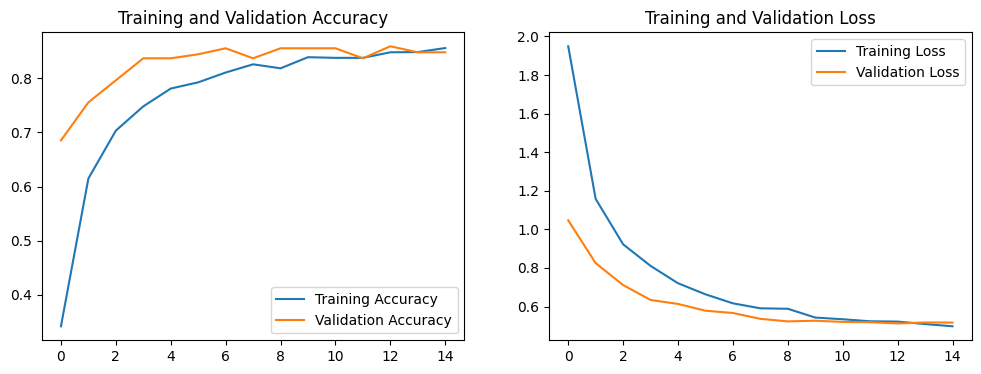

In [12]:
# acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
# val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
# loss = history.history['loss'] + fine_tune_history.history['loss']
# val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 


# acc =  fine_tune_history.history['accuracy']
# val_acc = fine_tune_history.history['val_accuracy']
# loss =  fine_tune_history.history['loss']
# val_loss =  fine_tune_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
model.save('tomato.h5')
# model.save('faruqmob3000.keras')

In [16]:

m1 = '/Users/abdulmateen/tensorflow-test/mlproject/segmentation/tomato.h5'
m2 = '/Users/abdulmateen/tensorflow-test/mlproject/segmentation/notebook/faruqmobtest3000-1.h5'
model = tf.keras.models.load_model(m1)
# Register HEIF opener with Pill2w
pillow_heif.register_heif_opener()

def predict_single_image(model, image_path, class_names, target_size=(224, 224), show_image=True):
    """
    Make prediction on a single external image
    
    Args:
        model: Your trained Keras model
        image_path: Path to the image file
        class_names: List of class names (same order as training)
        target_size: Input size expected by model (224, 224)
        show_image: Whether to display the image
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score (0-1)
        all_predictions: Array of all class probabilities
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed (handles HEIC, PNG with transparency, etc.)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to target size
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        
        # Get the predicted class and confidence
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        # Display the image if requested
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.2%})')
            plt.axis('off')
            plt.show()
        
        return predicted_class, confidence, predictions[0]
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def predict_multiple_images(model, image_folder, class_names, target_size=(224, 224), show_results=True):
    """
    Make predictions on multiple images in a folder
    
    Args:
        model: Your trained Keras model
        image_folder: Path to folder containing images
        class_names: List of class names
        target_size: Input size expected by model
        show_results: Whether to display results
    
    Returns:
        results: List of dictionaries with results for each image
    """
    results = []
    
    # Get all image files in the folder
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic')
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(image_extensions)]
    
    print(f"Found {len(image_files)} images to process")
    
    for i, filename in enumerate(image_files):
        image_path = os.path.join(image_folder, filename)
        print(f"\nProcessing {i+1}/{len(image_files)}: {filename}")
        
        predicted_class, confidence, all_predictions = predict_single_image(
            model, image_path, class_names, target_size, show_image=show_results
        )
        
        if predicted_class is not None:
            result = {
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_predictions': all_predictions
            }
            results.append(result)
            
            print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")
        else:
            print(f"Failed to process {filename}")
    
    return results

def show_top_predictions(predictions, class_names, top_n=3):
    """
    Display top N predictions with their probabilities
    
    Args:
        predictions: Array of prediction probabilities
        class_names: List of class names
        top_n: Number of top predictions to show
    """
    # Get indices of top predictions
    top_indices = np.argsort(predictions)[::-1][:top_n]
    
    print(f"\nTop {top_n} predictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[idx]:.2%}")

# Example usage functions
def predict_with_your_model(image_path):
    """
    Wrapper function using your specific model and class names
    """
    # Your class names from the training
    class_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Target_Spot', 'Two-spotted_spider_mite', 'Yellow_Leaf_Curl_Virus', 'healthy', 'mosaic_virus']
    
    # Make prediction
    predicted_class, confidence, all_predictions = predict_single_image(
        model, image_path, class_names, target_size=(224, 224), show_image=True
    )
    
    if predicted_class is not None:
        print(f"\nPredicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        
        # Show top 3 predictions
        show_top_predictions(all_predictions, class_names, top_n=3)
    
    return predicted_class, confidence, all_predictions

# Example usage:
# predicted_class, confidence, all_predictions = predict_with_your_model('/path/to/your/image.jpg')

# For batch processing:
# results = predict_multiple_images(model, '/path/to/image/folder', class_names)

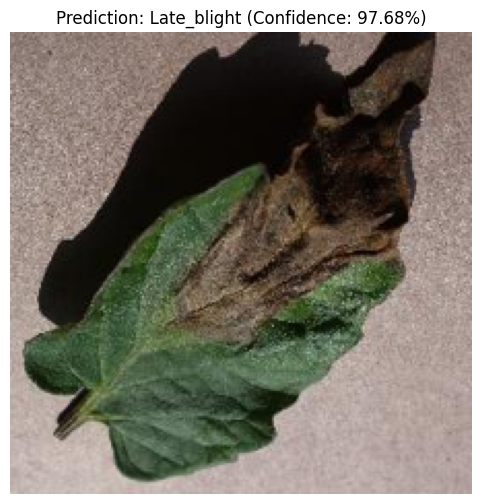


Predicted class: Late_blight
Confidence: 97.68%

Top 3 predictions:
1. Late_blight: 97.68%
2. Early_blight: 2.21%
3. Leaf_Mold: 0.03%


In [17]:
predicted_class, confidence, all_predictions = predict_with_your_model('/Users/abdulmateen/Downloads/tomato/Late_blight/image (29).JPG')


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step


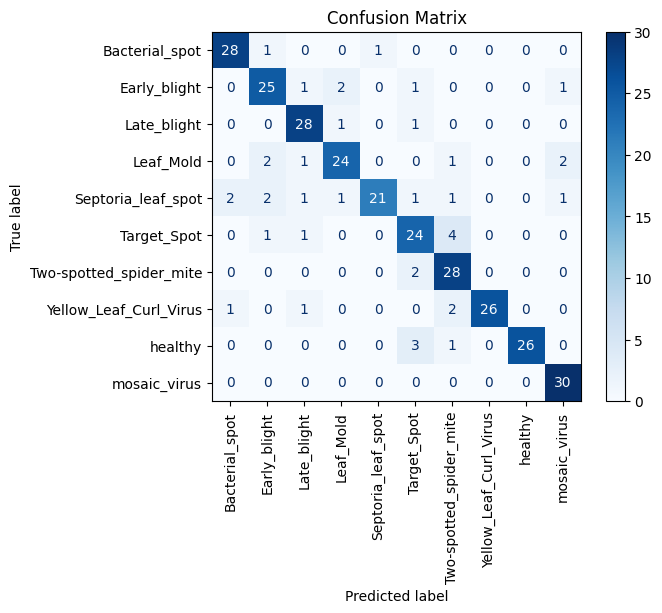

In [18]:

def plot_confusion_matrix(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


plot_confusion_matrix(model, test_images, test_labels, class_names)


In [ ]:

def print_classification_report(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    print(classification_report(y_test, y_pred_labels, target_names=class_names))


In [84]:

print_classification_report(model, test_images, test_labels, class_names)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step
              precision    recall  f1-score   support

  Bitterleaf       1.00      1.00      1.00        38
      Efirin       0.92      0.97      0.95        37
       Ewedu       0.97      0.97      0.97        40
   amunututu       1.00      1.00      1.00        36
     elegede       1.00      1.00      1.00        25
       soko        1.00      0.94      0.97        33
       tete        1.00      1.00      1.00        31
        ugu        1.00      1.00      1.00        28
 uziza leave       1.00      1.00      1.00        29
   waterleaf       1.00      1.00      1.00        38

    accuracy                           0.99       335
   macro avg       0.99      0.99      0.99       335
weighted avg       0.99      0.99      0.99       335



In [ ]:


def evaluate_model(model, X_test, y_test, class_names):
    # Predict and convert to label indices
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Accuracy score
    acc = accuracy_score(y_test, y_pred_labels)
    print(f"Accuracy: {acc:.4f}\n")

 

evaluate_model(model, test_images, test_labels, class_names)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step
Accuracy: 0.9881



# Efficient Net


In [96]:


# Define number of classes
num_classes = 10  # Replace with your actual number of classes

# Input layer
inputs = keras.Input(shape=(224, 224, 3))

# Rescale input images (optional – handled in data augmentation pipeline)
x = layers.Rescaling(1./255)(inputs)
# x = inputs  # Use input directly if rescaling is done elsewhere

# Load base model2
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model2

# Pass through base model2
x = base_model(x, training=False)

# Add pooling, dropout, and final dense layer
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax',
 kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Build model2
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile model2
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model2 summary
model2.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [100]:
history2 = model2.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=15,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# history2 = model2.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator)
# )


Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 511ms/step - accuracy: 0.0959 - loss: 2.3535 - val_accuracy: 0.1159 - val_loss: 2.3213
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 503ms/step - accuracy: 0.1114 - loss: 2.3506 - val_accuracy: 0.1192 - val_loss: 2.3328
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.1102 - loss: 2.3500 - val_accuracy: 0.0927 - val_loss: 2.3232
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 469ms/step - accuracy: 0.1026 - loss: 2.3408 - val_accuracy: 0.1192 - val_loss: 2.3205
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - accuracy: 0.1026 - loss: 2.3528 - val_accuracy: 0.0993 - val_loss: 2.3217
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 475ms/step - accuracy: 0.1136 - loss: 2.3414 - val_accuracy: 0.1159 - val_loss: 2.3289
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 493ms/step - accuracy: 0.1109 - loss: 2.3398 - val_accuracy: 0.1192 - val_loss: 2.3145
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 489ms/step - accuracy: 0.1081 - loss: 2.3432 - val_accu

In [101]:
# Unfreeze last part of base model2
base_model.trainable = True
fine_tune_at = 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history2 = model2.fit(
    train_images,train_labels,
    validation_data=(val_images,val_labels),
    epochs=10,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32
)
# fine_tune_history2 = model2.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=8,
#     verbose=1,
#     callbacks=[early_stop],
#     steps_per_epoch=len(train_images) // 32,
# )


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.1291 - loss: 2.3395 - val_accuracy: 0.1126 - val_loss: 2.3187
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.3742 - loss: 1.9788 - val_accuracy: 0.0795 - val_loss: 2.3262
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5906 - loss: 1.6610 - val_accuracy: 0.0828 - val_loss: 2.3752
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6992 - loss: 1.4119 - val_accuracy: 0.1358 - val_loss: 2.3314
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


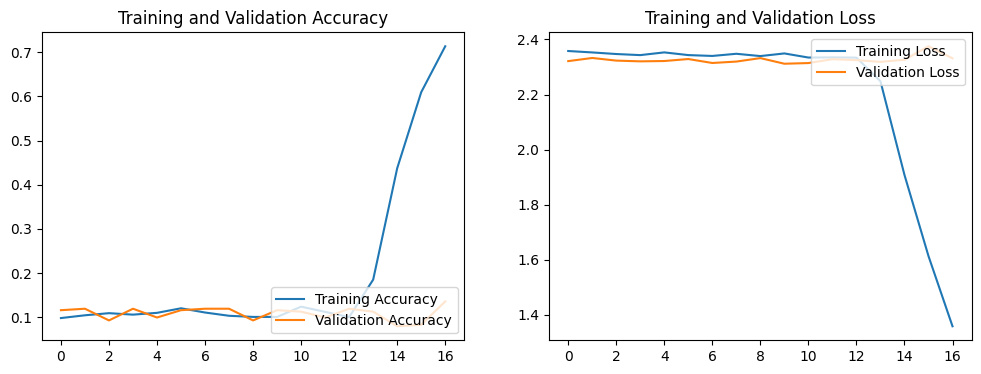

In [104]:
acc = history2.history['accuracy'] + fine_tune_history2.history['accuracy']
val_acc = history2.history['val_accuracy'] + fine_tune_history2.history['val_accuracy']
loss = history2.history['loss'] + fine_tune_history2.history['loss']
val_loss = history2.history['val_loss'] + fine_tune_history2.history['val_loss']

# acc = history2.history2['accuracy'] 
# val_acc = history2.history2['val_accuracy'] 
# loss = history2.history2['loss'] 
# val_loss = history2.history2['val_loss'] 


# acc =  fine_tune_history2.history2['accuracy']
# val_acc = fine_tune_history2.history2['val_accuracy']
# loss =  fine_tune_history2.history2['loss']
# val_loss =  fine_tune_history2.history2['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model2.save('faruqmob3000.keras')

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 536ms/step


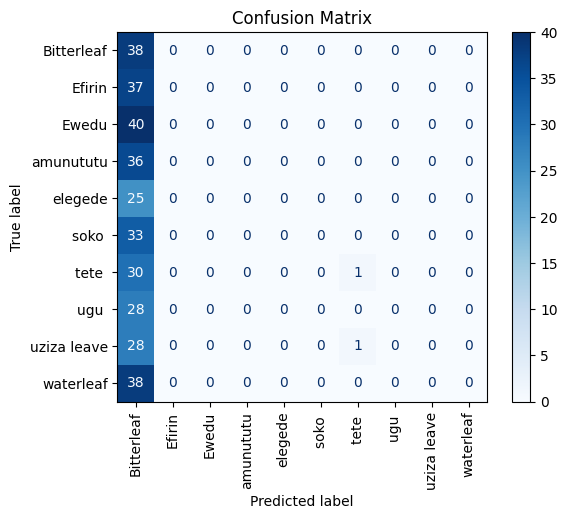

In [105]:

def plot_confusion_matrix(model2, X_test, y_test, class_names):
    y_pred = model2.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


plot_confusion_matrix(model2, test_images, test_labels, class_names)


In [23]:
import pandas as pd

df = pd.read_csv("/Users/abdulmateen/Downloads/Clean Dataset/Lassa_cases(2017-2020).csv")
df2 = pd.read_csv("/Users/abdulmateen/Downloads/Clean Dataset/Precipitation/akokosouth.csv")
df.columns

Index(['LGA', 'Year', 'Week', 'variable', 'value', 'LGA_known', 'Date'], dtype='object')

In [24]:
df2.columns

Index(['Date', 'Precipitation'], dtype='object')

In [28]:
df['LGA'].unique()

array(['Akoko South West', 'Akure North', 'Akure South', 'Owo'],
      dtype=object)

In [8]:
import pandas as pd
import numpy as np
import os

def organize_lassa_fever_data_by_lga(case_file, weather_base_path, output_file):
    """
    Loads Lassa fever case data and daily, LGA-specific weather data, creates a 
    model-ready dataset with lagged features, and saves it. This version handles
    the specific multi-column format of the air temperature files.

    Args:
        case_file (str): Path to the Lassa_cases.csv file.
        weather_base_path (str): Path to the base directory containing weather folders 
                                 (e.g., './weather_data/').
        output_file (str): Path to save the final processed CSV file.
    """
    print("--- 1. Loading Lassa Fever Case Data ---")
    try:
        df_cases = pd.read_csv(case_file)
    except FileNotFoundError:
        print(f"Error: Case file not found at '{case_file}'.")
        return

    # Standardize LGA names to match potential filenames
    df_cases['LGA'] = df_cases['LGA'].str.strip()
    unique_lgas = df_cases['LGA'].unique()
    print(f"Found LGAs: {unique_lgas}")

    all_weather_weekly_lagged = []

    print("\n--- 2. Processing Weather Data for each LGA ---")
    for lga in unique_lgas:
        print(f"  -> Processing {lga}...")
        try:
            # Construct file paths for the current LGA
            temp_path = os.path.join(weather_base_path, 'air_temp', f'{lga}.csv')
            precip_path = os.path.join(weather_base_path, 'precipitation', f'{lga}.csv')
            humidity_path = os.path.join(weather_base_path, 'relative_humidity', f'{lga}.csv')

            # --- MODIFICATION START ---
            # Load the temperature data and select only the Kelvin column for consistency.
            df_temp = pd.read_csv(temp_path)
            # Check if the expected columns exist
            if 'temp(F)' in df_temp.columns:
                df_temp = df_temp[['Date', 'temp(F)']]
                df_temp.rename(columns={'temp(F)': 'Air_Temp'}, inplace=True)
            else:
                # Fallback for other possible column names if needed
                print(f"    ⚠️  Warning: 'temp(F)' column not found in {temp_path}. Check file format.")
                continue
            # --- MODIFICATION END ---
            
            df_precip = pd.read_csv(precip_path)
            df_humidity = pd.read_csv(humidity_path)

            # Merge daily weather data for this LGA
            df_weather_lga = pd.merge(df_temp, df_precip, on='Date', how='outer')
            df_weather_lga = pd.merge(df_weather_lga, df_humidity, on='Date', how='outer')
            df_weather_lga['Date'] = pd.to_datetime(df_weather_lga['Date'], dayfirst=True)
            df_weather_lga = df_weather_lga.sort_values('Date').reset_index(drop=True)

            # Aggregate daily to weekly
            df_weather_lga['Year'] = df_weather_lga['Date'].dt.isocalendar().year
            df_weather_lga['Week'] = df_weather_lga['Date'].dt.isocalendar().week
            
            weekly_agg_rules = {
                'Precipitation': 'sum',
                'Air_Temp': 'mean',
                'Relative_Humidity': 'mean'
            }
            df_weekly_lga = df_weather_lga.groupby(['Year', 'Week']).agg(weekly_agg_rules).reset_index()
            df_weekly_lga.rename(columns={
                'Precipitation': 'total_weekly_precip',
                'Air_Temp': 'avg_weekly_temp',
                'Relative_Humidity': 'avg_weekly_humidity'
            }, inplace=True)

            # Create lagged features
            features_to_lag = ['total_weekly_precip', 'avg_weekly_temp', 'avg_weekly_humidity']
            lag_periods = [2, 3, 4, 5, 6]
            for feature in features_to_lag:
                for lag in lag_periods:
                    df_weekly_lga[f"{feature}_{lag}_weeks_ago"] = df_weekly_lga[feature].shift(lag)
            
            df_weekly_lga['LGA'] = lga # Add LGA identifier
            all_weather_weekly_lagged.append(df_weekly_lga)

        except FileNotFoundError as e:
            print(f"    ⚠️  Warning: Could not find a weather file for {lga}. Skipping. Details: {e}")
            continue
    
    # Combine all processed LGA weather data into one dataframe
    df_weather_final = pd.concat(all_weather_weekly_lagged, ignore_index=True)

    print("\n--- 3. Merging Case Data with Lagged Weather Data ---")
    df_cases['Date'] = pd.to_datetime(df_cases['Date'], dayfirst=True)
    df_cases_confirmed = df_cases[df_cases['variable'] == 'Confirmed'].copy()
    df_cases_confirmed.rename(columns={'value': 'Confirmed_Cases'}, inplace=True)
    
    # Merge on LGA, Year, and Week
    df_final = pd.merge(df_cases_confirmed, df_weather_final, on=['LGA', 'Year', 'Week'], how='left')

    print("\n--- 4. Final Feature Engineering and Cleanup ---")
    df_final['Month'] = df_final['Date'].dt.month
    df_final['Quarter'] = df_final['Date'].dt.quarter
    
    # One-hot encode the 'LGA' column
    lga_dummies = pd.get_dummies(df_final['LGA'], prefix='LGA')
    df_final = pd.concat([df_final, lga_dummies], axis=1)
    
    # Drop original and intermediate columns
    df_final.drop(columns=['LGA', 'variable'], inplace=True)
    
    # Drop rows with NaN values created by the lagging process
    df_final.dropna(inplace=True)
    
    # Save the final dataset
    df_final.to_csv(output_file, index=False)
    print(f"\n✅ Successfully created the model-ready dataset at: {output_file}")
    print("\n--- Sample of the final data ---")
    print(df_final.head())
    print("\n--- Columns in the final dataset ---")
    print(df_final.columns.tolist())




In [27]:
# --- HOW TO RUN ---
# 1. Create a main directory for your weather data (e.g., 'weather_data').
# 2. Inside it, create three subdirectories: 'air_temp', 'precipitation', 'relative_humidity'.
# 3. Place the corresponding LGA-named CSV files into each subdirectory.
#    Example path: './weather_data/air_temp/Owo.csv'

# Define file and directory paths
LASSA_CASE_FILE = '/Users/abdulmateen/Downloads/Lassa_cases(2017-2020).csv'
WEATHER_BASE_PATH = '/Users/abdulmateen/Downloads/Clean Dataset' # Base folder containing the weather subdirectories
OUTPUT_FILE = 'Lassa_Fever_Model_Ready_By_LGA.csv'

# Run the data organization function
organize_lassa_fever_data_by_lga(LASSA_CASE_FILE, WEATHER_BASE_PATH, OUTPUT_FILE)


--- 1. Loading Lassa Fever Case Data ---
Found LGAs: ['Akoko South West' 'Akure North' 'Akure South' 'Owo']

--- 2. Processing Weather Data for each LGA ---
  -> Processing Akoko South West...
  -> Processing Akure North...
  -> Processing Akure South...
  -> Processing Owo...

--- 3. Merging Case Data with Lagged Weather Data ---

--- 4. Final Feature Engineering and Cleanup ---

✅ Successfully created the model-ready dataset at: Lassa_Fever_Model_Ready_By_LGA.csv

--- Sample of the final data ---
     Year  Week  Confirmed_Cases  LGA_known       Date  total_weekly_precip  \
269  2018     1              0.0          1 2018-01-01                  0.0   
270  2018     1              0.0          1 2018-01-01                  0.0   
271  2018     1              0.0          1 2018-01-01                  0.0   
272  2018     1              0.0          1 2018-01-01                  0.0   
273  2018     1              0.0          1 2018-01-01                  0.0   

     avg_weekly_temp 

/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/ipykernel_98364/1098504048.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather_lga['Date'] = pd.to_datetime(df_weather_lga['Date'], dayfirst=True)
/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/ipykernel_98364/1098504048.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather_lga['Date'] = pd.to_datetime(df_weather_lga['Date'], dayfirst=True)
/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/ipykernel_98364/1098504048.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather_lga['Date'] = pd.to_date

In [33]:
df_humidity = pd.read_csv('Lassa_Fever_Model_Ready_By_LGA.csv')

# Rename to match the expected name
# df_humidity.rename(columns={'Relative Humidity': 'Relative_Humidity'}, inplace=True)
df_humidity['Confirmed_Cases'].unique()


array([ 0.,  1.,  5.,  2., 18.,  7., 12., 13.,  9.,  3., 22.,  4.,  6.,
       15., 10.])

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# --- 1. Load and Prepare the Data ---
print("⚙️  Step 1: Loading and Preparing Data...")
try:
    df = pd.read_csv('model_ready_data.csv', parse_dates=['Date'])
except FileNotFoundError:
    print("Error: 'model_ready_data.csv' not found. Please run your data preparation script first.")
    exit()

# Sort by date to ensure chronological order for time-series splitting
df = df.sort_values('Date').reset_index(drop=True)

# Define the target variable and features
TARGET = 'Confirmed_Cases'
# Drop the date as it's not a direct input feature for the model
features = [col for col in df.columns if col not in ['Date', TARGET]]

X = df[features]
y = df[[TARGET]] # Keep y as a DataFrame for the scaler

print(f"Data loaded with {len(X)} samples and {len(features)} features.")

# --- 2. Scale the Data ---
print("⚙️  Step 2: Scaling Data...")
# LSTMs are sensitive to the scale of the data. We scale all features to be between 0 and 1.
scaler_x = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)

# --- 3. Reshape Data for LSTM ---
# The LSTM layer expects a 3D input shape: (samples, timesteps, features)
# Since your features already contain lagged data, we'll treat each row 
# as a single timestep.
print("⚙️  Step 3: Reshaping Data for LSTM input...")
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
print(f"New data shape: {X_reshaped.shape}")

# --- 4. Split into Training and Test Sets ---
# For time series data, we split chronologically, not randomly.
print("⚙️  Step 4: Splitting into Training and Test Sets...")
train_split = 0.8
split_index = int(len(X_reshaped) * train_split)

X_train, X_test = X_reshaped[:split_index], X_reshaped[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- 5. Build and Compile the LSTM Model ---
print("🧠 Step 5: Building the LSTM Model...")
model = Sequential([
    # Input LSTM layer. `input_shape` is (timesteps, features).
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Dropout layer to prevent overfitting
    
    LSTM(units=50), # A second LSTM layer
    Dropout(0.2),
    
    # The output layer for our regression prediction
    Dense(units=1)
])

# Compile the model with a standard optimizer and loss function for regression
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- 6. Train the Model ---
print("\n🏋️‍♀️ Step 6: Training the Model...")
# Use EarlyStopping to prevent overfitting by stopping when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# --- 7. Evaluate and Visualize Results ---
print("\n📊 Step 7: Evaluating and Visualizing Results...")
# Make predictions on the test data
predictions_scaled = model.predict(X_test)

# Invert the scaling to get actual case numbers
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate error metrics
mae = np.mean(np.abs(predictions - y_test_actual))
rmse = np.sqrt(np.mean((predictions - y_test_actual)**2))

print(f"\nModel Evaluation on Test Data:")
print(f"  -> Mean Absolute Error (MAE): {mae:.2f}")
print(f"  -> Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(df['Date'][split_index:], y_test_actual, color='blue', label='Actual Cases')
plt.plot(df['Date'][split_index:], predictions, color='red', linestyle='--', label='Predicted Cases')
plt.title('Lassa Fever Case Forecasting using LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

⚙️  Step 1: Loading and Preparing Data...
Error: 'model_ready_data.csv' not found. Please run your data preparation script first.


NameError: name 'df' is not defined

: 